In [ ]:
import kagglehub
lainguyn123_student_performance_factors_path = kagglehub.dataset_download('lainguyn123/student-performance-factors')
print('Data source import complete.')

Data source import complete.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from scipy.stats import kendalltau, spearmanr
import joblib

**Load Data**

In [ ]:
data = pd.read_csv(f'{lainguyn123_student_performance_factors_path}/StudentPerformanceFactors.csv')
data.info()
data.describe()
data.head()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   object
 12  School_Type                 6607 non-null   object
 13  Peer_Influence              6607 non-null   obje

,0
Hours_Studied,0
Attendance,0
Parental_Involvement,0
Access_to_Resources,0
Extracurricular_Activities,0
Sleep_Hours,0
Previous_Scores,0
Motivation_Level,0
Internet_Access,0
Tutoring_Sessions,0


**Handle Missing Values**

In [ ]:
data['Teacher_Quality'].fillna(data['Teacher_Quality'].mode()[0], inplace=True)
data['Parental_Education_Level'].fillna(data['Parental_Education_Level'].mode()[0], inplace=True)
data['Distance_from_Home'].fillna(data['Distance_from_Home'].mode()[0], inplace=True)

/tmp/ipython-input-1860880027.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Teacher_Quality'].fillna(data['Teacher_Quality'].mode()[0], inplace=True)
/tmp/ipython-input-1860880027.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].metho

**EDA**

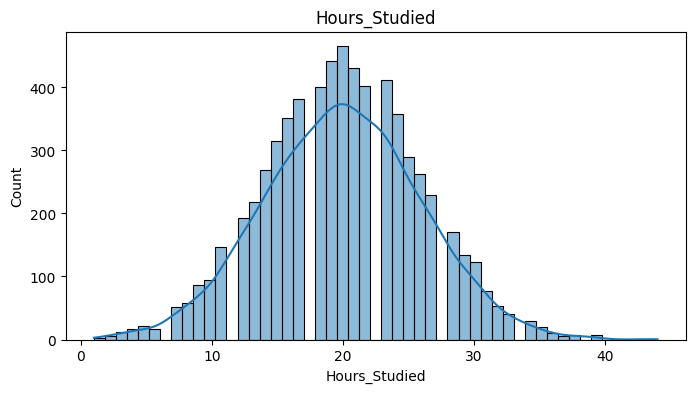

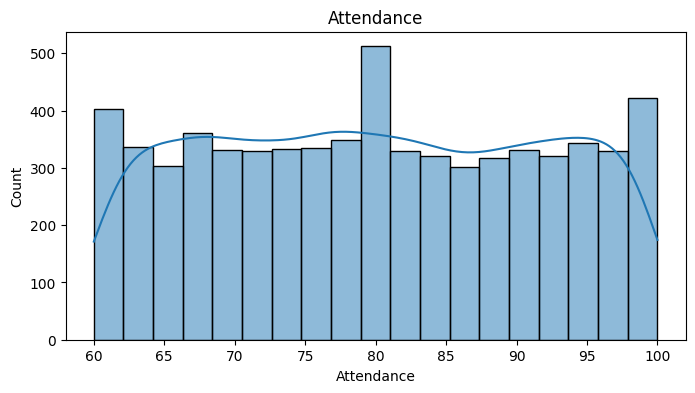

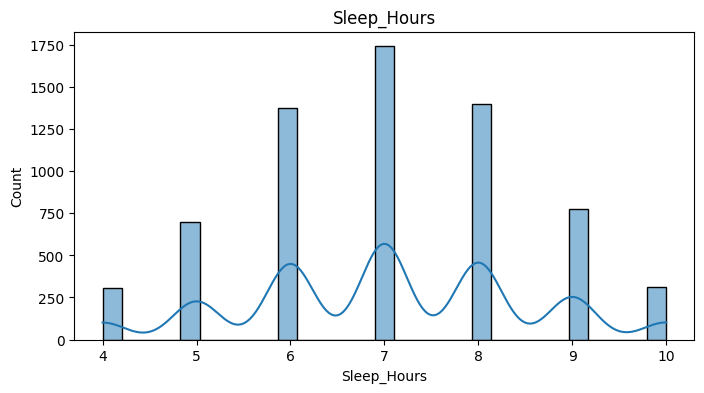

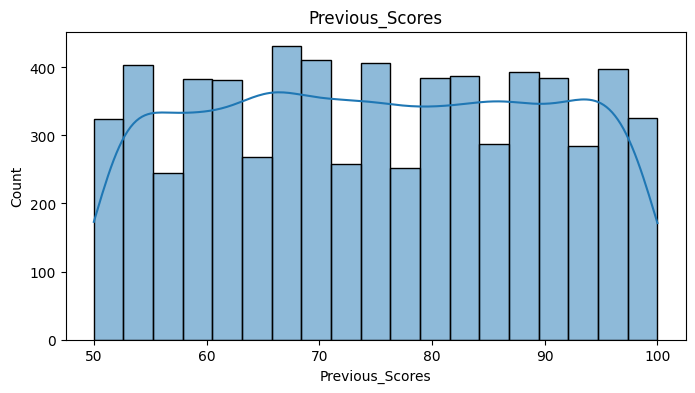

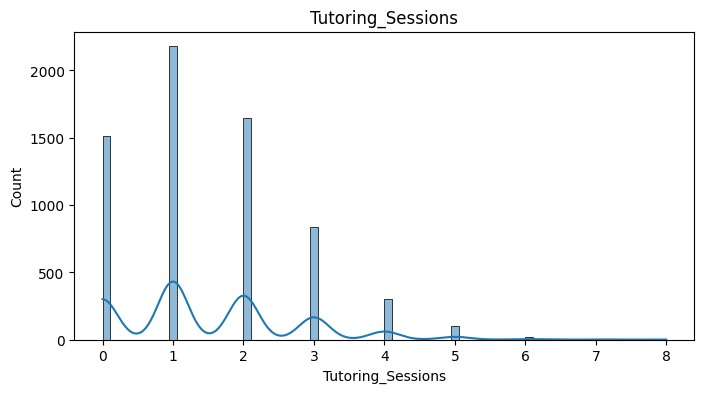

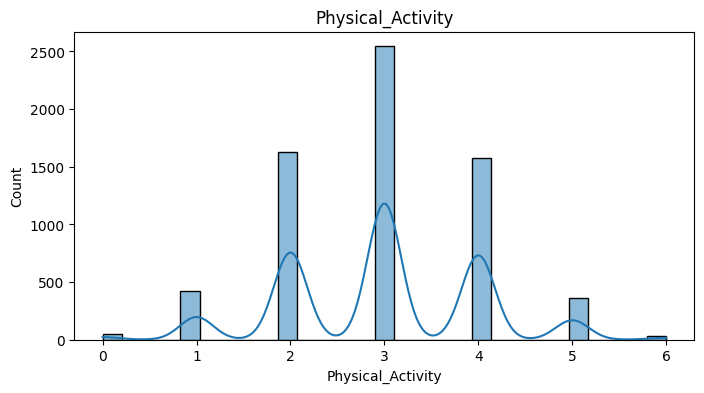

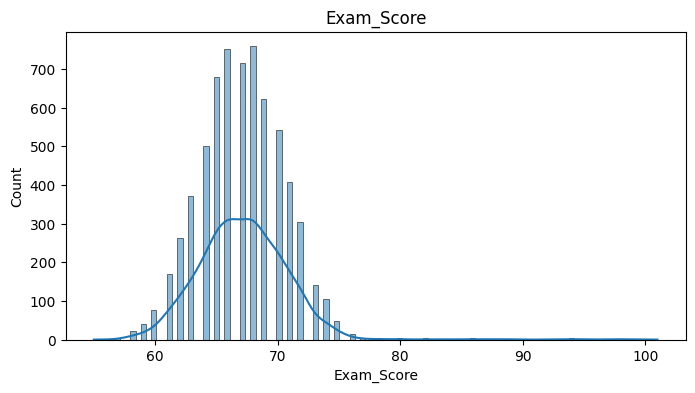

In [ ]:
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(data[col], kde=True)
    plt.title(f'{col}')
    plt.show()

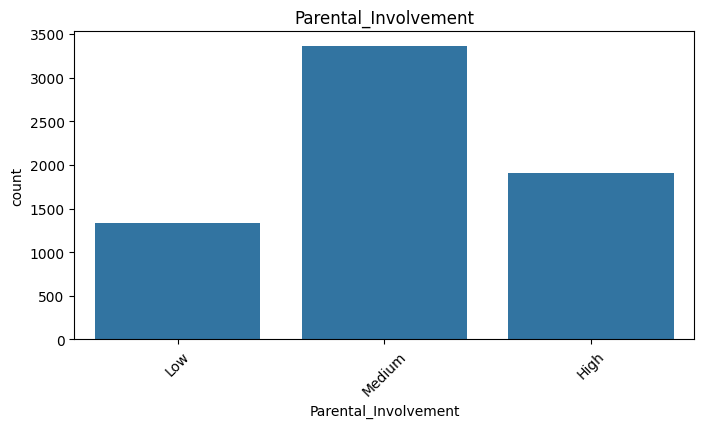

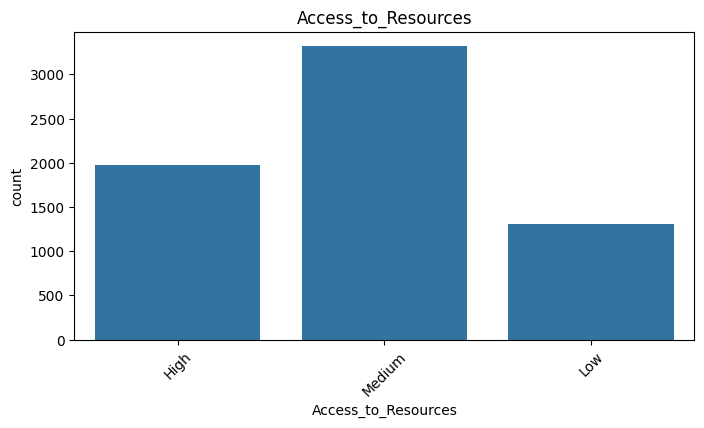

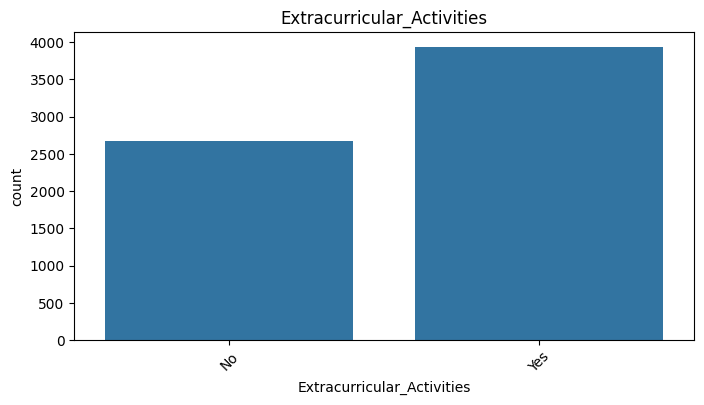

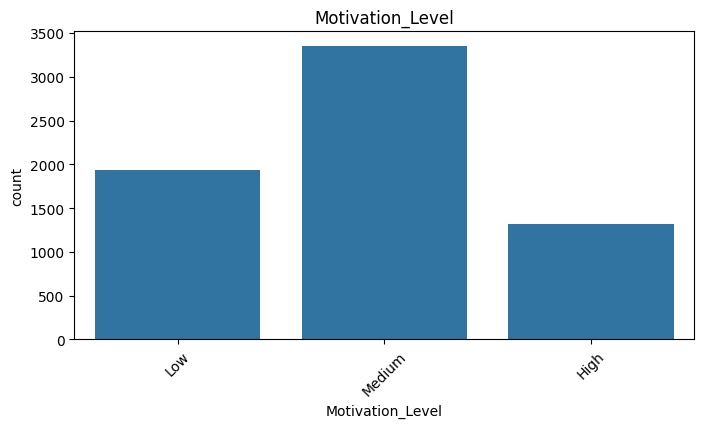

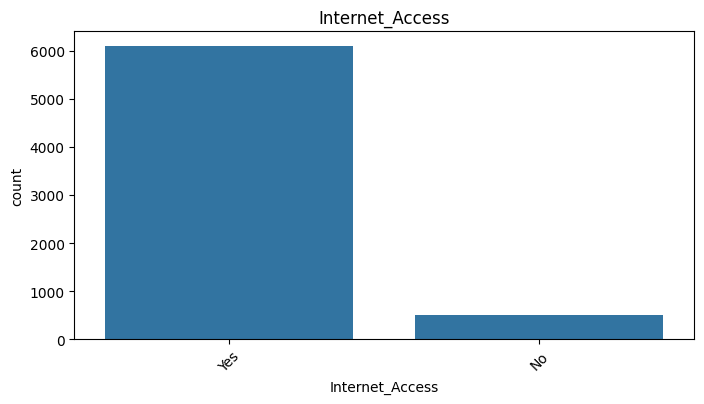

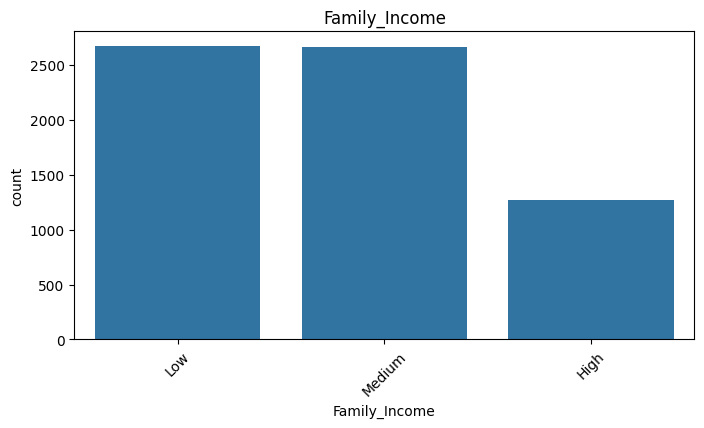

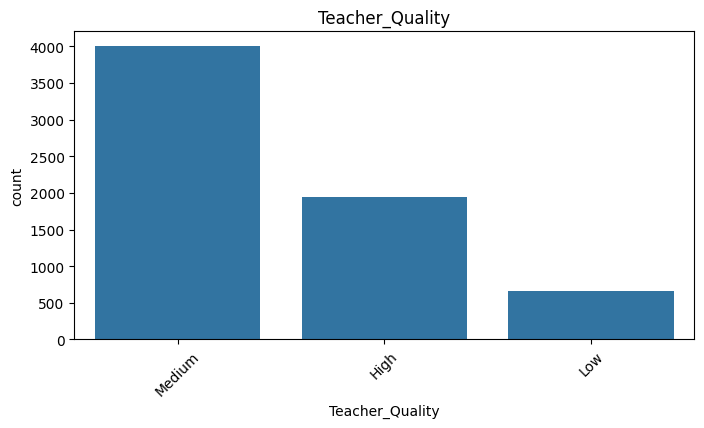

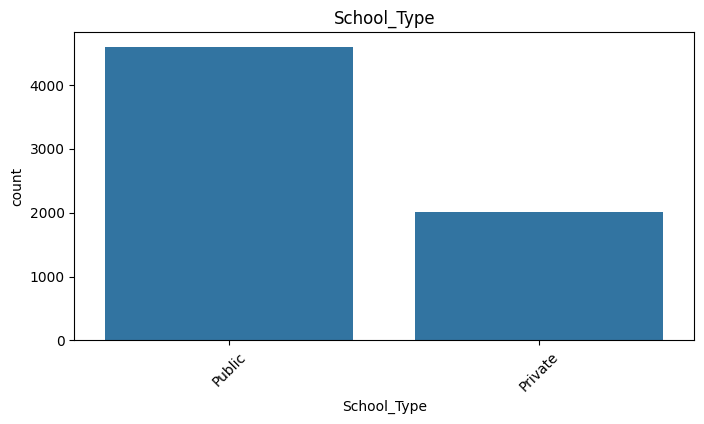

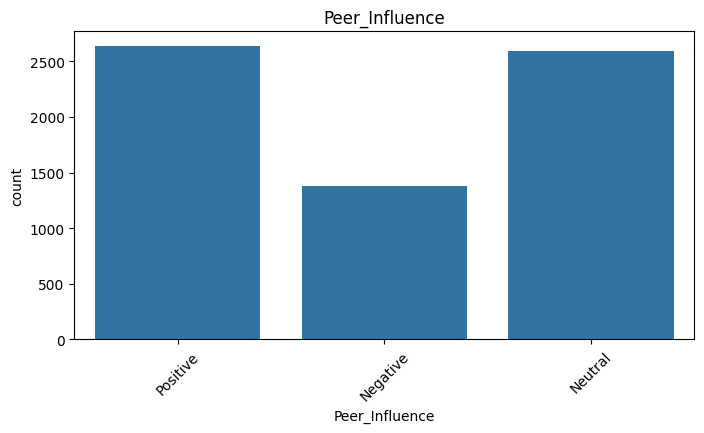

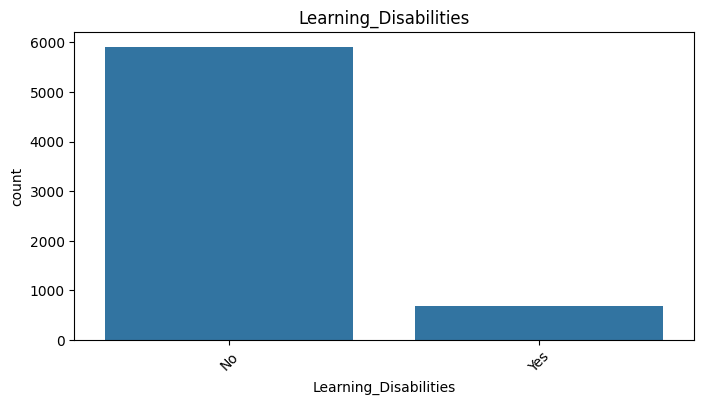

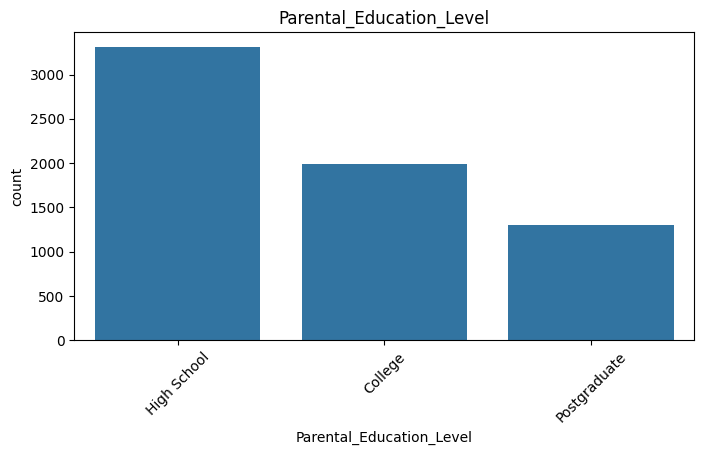

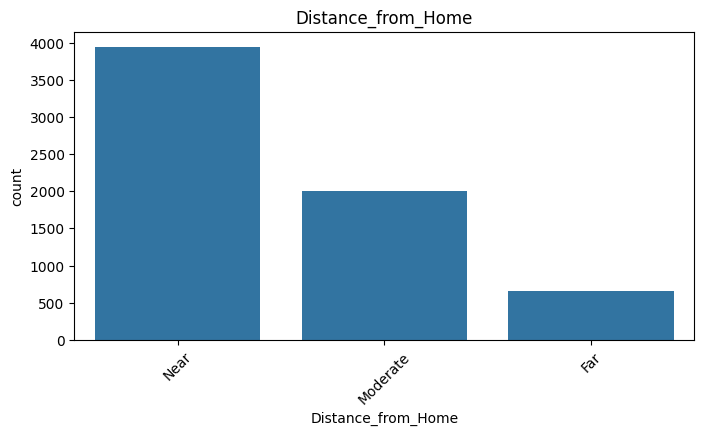

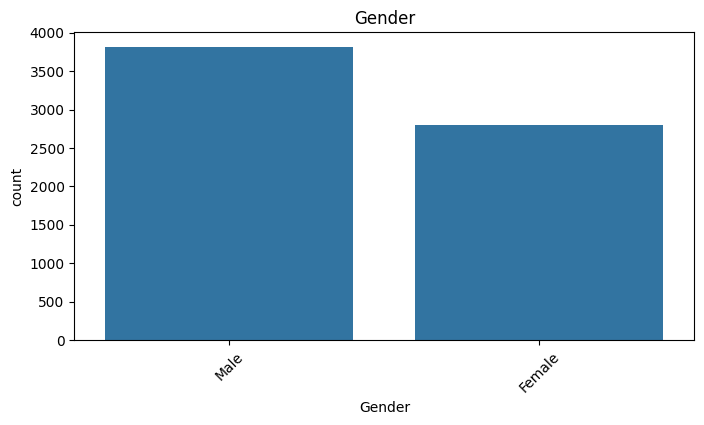

In [ ]:
categorical_cols = data.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=data[col])
    plt.title(f'{col}')
    plt.xticks(rotation=45)
    plt.show()

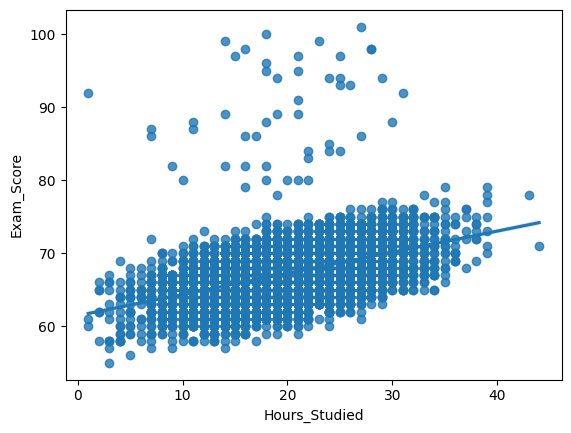

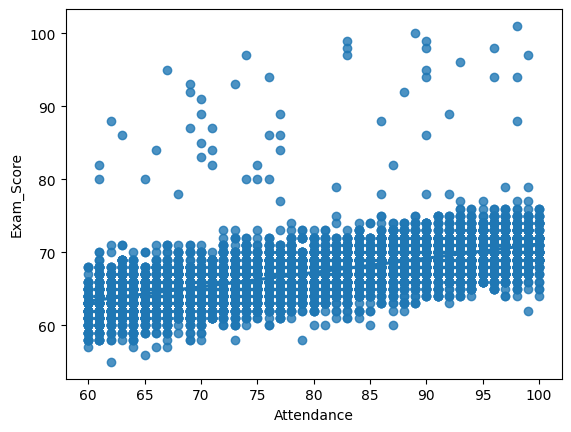

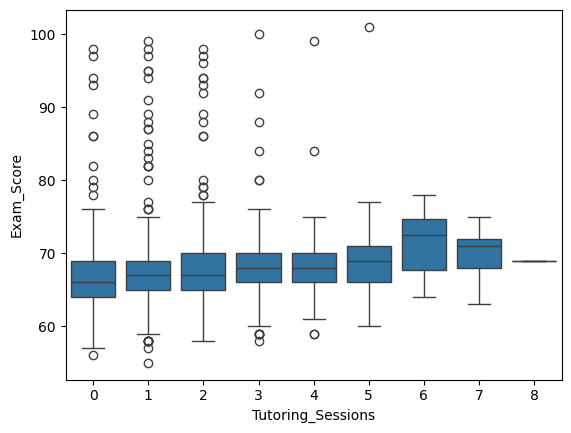

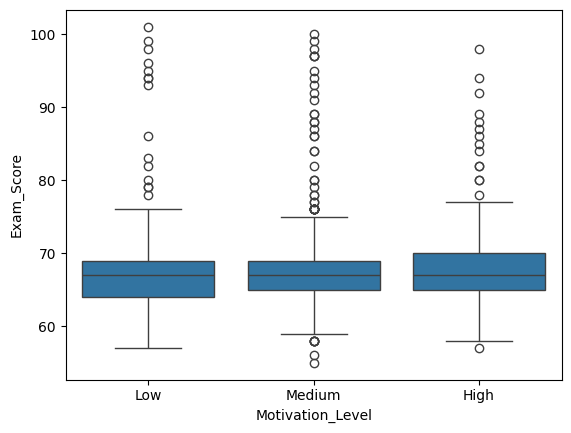

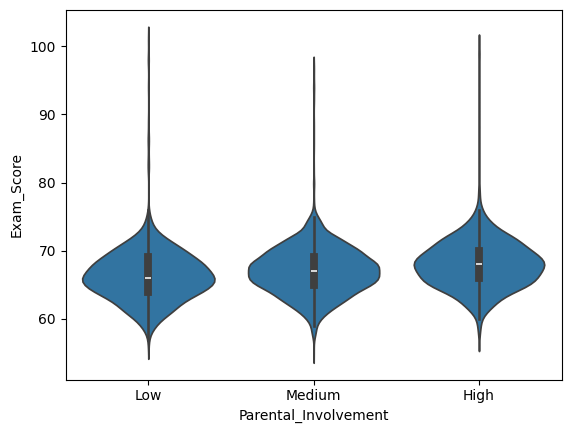

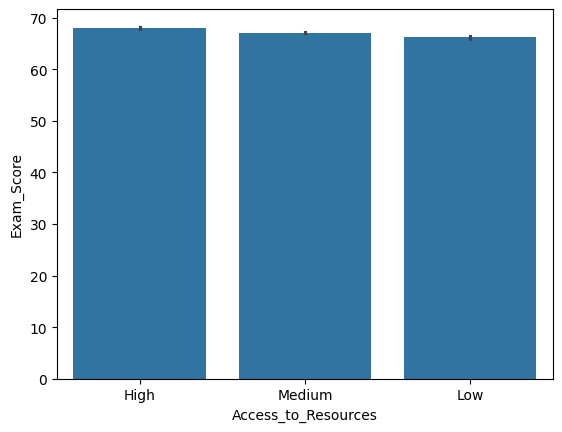

In [ ]:
sns.regplot(data=data, x='Hours_Studied', y='Exam_Score')
plt.show()

sns.regplot(data=data, x='Attendance', y='Exam_Score')
plt.show()

sns.boxplot(data=data, x='Tutoring_Sessions', y='Exam_Score')
plt.show()

sns.boxplot(data=data, x='Motivation_Level', y='Exam_Score')
plt.show()

sns.violinplot(data=data, x='Parental_Involvement', y='Exam_Score')
plt.show()

sns.barplot(data=data, x='Access_to_Resources', y='Exam_Score')
plt.show()

**Outlier Handling**

In [ ]:
for col in numerical_cols:
    q1, q3 = data[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    data[col] = np.where(data[col] < lower, lower, data[col])
    data[col] = np.where(data[col] > upper, upper, data[col])

**Encoding**

In [ ]:
ordinal_cols = ['Parental_Involvement','Access_to_Resources','Motivation_Level',
                'Family_Income','Teacher_Quality','Peer_Influence',
                'Parental_Education_Level','Distance_from_Home']
binary_cols = ['Extracurricular_Activities','Internet_Access','School_Type',
               'Learning_Disabilities','Gender']
ordinal_mappings = {
    'Parental_Involvement': ['Low', 'Medium', 'High'],
    'Access_to_Resources': ['Low', 'Medium', 'High'],
    'Motivation_Level': ['Low', 'Medium', 'High'],
    'Family_Income': ['Low', 'Medium', 'High'],
    'Teacher_Quality': ['Low', 'Medium', 'High'],
    'Peer_Influence': ['Negative', 'Neutral', 'Positive'],
    'Parental_Education_Level': ['High School','College','Postgraduate'],
    'Distance_from_Home': ['Near','Moderate','Far']
}

In [ ]:
for col in ordinal_cols:
    ord_encoder = OrdinalEncoder(categories=[ordinal_mappings[col]])
    data[col] = ord_encoder.fit_transform(data[[col]])

In [ ]:
for col in binary_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

**Correlation Heatmap**

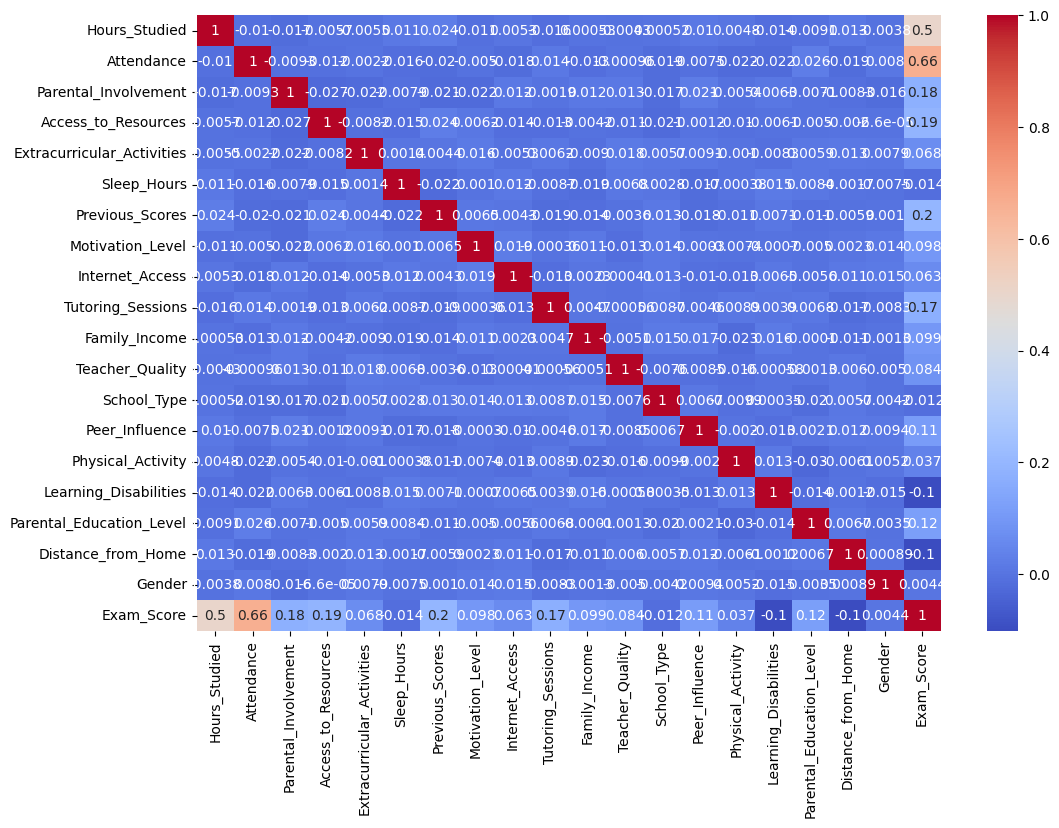

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.show()

**Linear Regression**

In [ ]:
X = data[['Hours_Studied']]
y = data['Exam_Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))

MSE: 8.18049482138428
R2: 0.2743358394062684


**Polynomial Regression**

In [ ]:
poly = PolynomialFeatures(degree=4)
polyreg = make_pipeline(poly, LinearRegression())
polyreg.fit(X_train, y_train)
joblib.dump(polyreg, 'polynomial_regression_model.pkl')

['polynomial_regression_model.pkl']

**Multi-feature Regression**

In [ ]:
X = data[['Hours_Studied','Previous_Scores','Attendance','Tutoring_Sessions',
          'Motivation_Level','Parental_Involvement','Access_to_Resources','Parental_Education_Level']]
y = data['Exam_Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
poly = PolynomialFeatures(degree=2)
polyreg = make_pipeline(poly, LinearRegression())
polyreg.fit(X_train, y_train)

print("Multi-feature MSE:", mean_squared_error(y_test, polyreg.predict(X_test)))
print("Multi-feature R2:", r2_score(y_test, polyreg.predict(X_test)))

Multi-feature MSE: 1.25706844563769
Multi-feature R2: 0.8884896893977644


**Feature Importance**

In [ ]:
numerical_cols = ['Hours_Studied','Attendance','Sleep_Hours','Previous_Scores',
                  'Tutoring_Sessions','Physical_Activity']
categorical_cols = ['Parental_Involvement','Access_to_Resources','Extracurricular_Activities',
                    'Motivation_Level','Internet_Access','Family_Income','Teacher_Quality',
                    'School_Type','Peer_Influence','Learning_Disabilities','Parental_Education_Level',
                    'Distance_from_Home','Gender']

pearson_corrs = {col: spearmanr(data[col], y)[0] for col in numerical_cols}
anova_selector = SelectKBest(score_func=f_classif, k='all')
anova_selector.fit(data[categorical_cols], y)
anova_scores = dict(zip(categorical_cols, anova_selector.scores_))

print("Top Features by Correlation/ANOVA:")
print(sorted({**pearson_corrs, **anova_scores}.items(), key=lambda x: abs(x[1]), reverse=True))

Top Features by Correlation/ANOVA:
[('Access_to_Resources', np.float64(16.584735700265245)), ('Parental_Involvement', np.float64(14.081423048424698)), ('Parental_Education_Level', np.float64(7.090058993340736)), ('Learning_Disabilities', np.float64(6.497907317032784)), ('Peer_Influence', np.float64(5.856525114100675)), ('Distance_from_Home', np.float64(5.570439887556605)), ('Motivation_Level', np.float64(4.877394886000273)), ('Family_Income', np.float64(4.770700836925126)), ('Teacher_Quality', np.float64(3.7949031150551225)), ('Extracurricular_Activities', np.float64(2.9510035542450304)), ('Internet_Access', np.float64(2.396757070986247)), ('Gender', np.float64(1.3837191247486595)), ('School_Type', np.float64(0.679020911920571)), ('Attendance', np.float64(0.6725434463669007)), ('Hours_Studied', np.float64(0.48114698039673587)), ('Previous_Scores', np.float64(0.1919877420169962)), ('Tutoring_Sessions', np.float64(0.16357001277125435)), ('Physical_Activity', np.float64(0.0292177531476565

In [ ]:
from sklearn.metrics import mean_absolute_error
results = {}

# Linear Regression
y_pred_lr = lr_model.predict(X_test)
results['Linear Regression'] = {
    "MSE": mean_squared_error(y_test, y_pred_lr),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_lr)),
    "MAE": mean_absolute_error(y_test, y_pred_lr),
    "R2": r2_score(y_test, y_pred_lr),
    "Accuracy": 1 - (mean_absolute_error(y_test, y_pred_lr) / np.mean(y_test))
}

# Polynomial Regression
y_pred_poly = polyreg.predict(X_test)
results['Polynomial Regression'] = {
    "MSE": mean_squared_error(y_test, y_pred_poly),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_poly)),
    "MAE": mean_absolute_error(y_test, y_pred_poly),
    "R2": r2_score(y_test, y_pred_poly),
    "Accuracy": 1 - (mean_absolute_error(y_test, y_pred_poly) / np.mean(y_test))
}

results_df = pd.DataFrame(results).T
print(results_df)




                            MSE      RMSE       MAE        R2  Accuracy
Linear Regression      1.253138  1.119437  0.756373  0.888838  0.988752
Polynomial Regression  1.257068  1.121191  0.758201  0.888490  0.988724


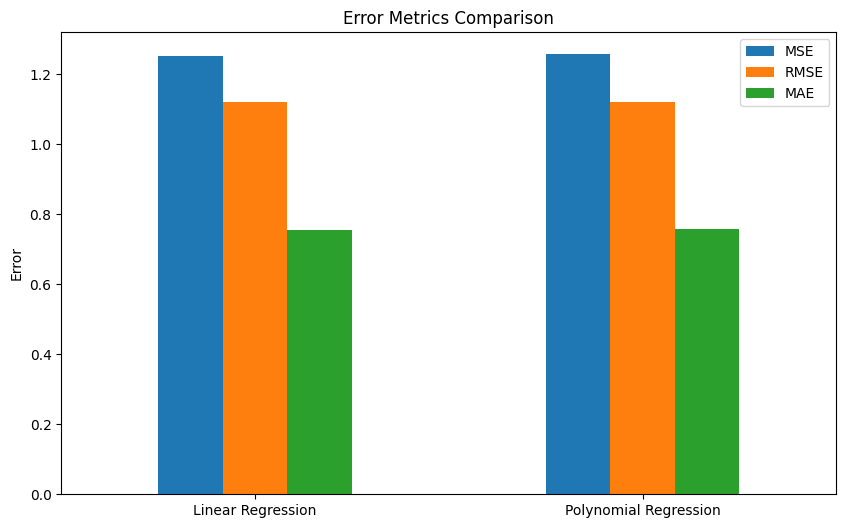

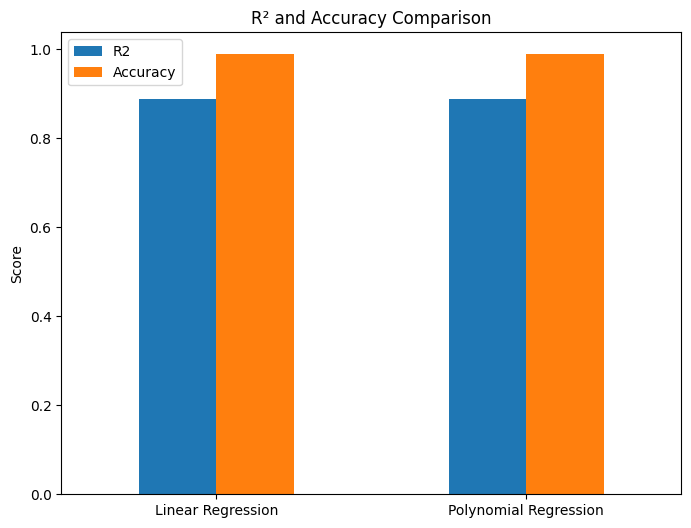

In [ ]:
results_df[['MSE','RMSE','MAE']].plot(kind='bar', figsize=(10,6))
plt.title("Error Metrics Comparison")
plt.ylabel("Error")
plt.xticks(rotation=0)
plt.show()

results_df[['R2','Accuracy']].plot(kind='bar', figsize=(8,6))
plt.title("R² and Accuracy Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.show()